<a href="https://colab.research.google.com/github/nataliasbsg/Transfer_Learning_Animals/blob/main/AnalisisdeResultados_MobV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importación de librerías

Se importan todas las librerías necesarias para realizar la red de clasificación de animales. En este caso se trabajará con librerías para trabajar con las imágenes y TensorFlow para las redes.

In [ ]:
# Importación de archivos desde drive
from google.colab import drive

# Tratamiento de imágenes
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import shutil
import zipfile


# Librerías para la red
import tensorflow as tf
import tensorflow_hub as hub

from datetime import datetime

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC


# Lectura de imágenes desde GitHub
Se accede a las imagenes contenidas en GitHub (https://github.com/nataliasbsg/Dataset_animales). En este enlace se pueden encontrar 6 carpetas:
1. BD_Familia: todas las imagenes con las cuales se ha entrenado la red, clasificadas en categorías y subcategorías.
2.BD_Familia_Test: imágenes que nunca entraron en el entrenamiento de la red y también clasificadas. Hay 100 fotos de cada especie y su objetivo es testear la red.
3.Modelos_Redes_Entrenados: son los modelos de las redes de familias y especies entrenados. El usuario no tiene necesidad de realizar nada con ellos, las redes los invocan cuando los requieren automáticamente.
4. RealTest: imágenes de animales sin clasificar. Estas imágenes son para mostrar una aplicación más real de las redes y es el usuario el que determina lo que ha acertado la red. Estas imágenes se han sacado aleatorimente de BD_Familia_Test. 
5. RealTest_little: versión anterior con menos cantidad de imágenes. Estas imágenes se han sacado aleatorimente de BD_Familia_Test. 
6. src: Carpeta que contiene los código que implementan las redes.

En este caso se van a utilizar las imágenes de BD_Familia_Test y están clasificadas en tres niveles de carpetas:
1. Base de Datos general. Una sola carpeta que contiene todas las familias de animales que se quieren estudiar. Por ejemplo: "Base de datos de animales".
2. Conjunto de carpetas de familias de animales que a su vez contienen las carpetas de especies animales de la misma familia (categories). Por ejemplo:  dentro de "Base de datos de animales" encontraríamos "Cánidos" y "Felinos".
3. Conjunto de carpetas de especies animales (subcategories). Contienen las imagenes con las que se va a trabajar. Por ejemplo: dentro de "Felinos" encontraríamos "Linces" y "Gatos".


Se estudiará la pertenencia a las familias de cada imagen y para ello se numerará la cantidad de imágenes de cada familia (no de cada especie) y se hará una copia de las imágenes clasificadas en la máquina virtual en la carpeta tmp (/tmp).

En este caso las familias y las especies de cada una son las siguientes:
0. Cánidos: zorros.
1. Cérvidos: ciervos y gamos.
2. Felinos: gatos y linces.
3. Herpéstidos: meloncillos.
4. Lepóridos: conejos y liebres.
5. Mustélidos: tejones.
6. Suidos: jabalíes.
7. Vivérridos: ginetas.

In [3]:
!wget --no-check-certificate \
    "https://github.com/nataliasbsg/Transfer_Learning_Animals/archive/refs/heads/master.zip" \
    -O "/tmp/Transfer_Learning_Animals.zip"

zip_ref = zipfile.ZipFile('/tmp/Transfer_Learning_Animals.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

--2022-07-16 17:39:44--  https://github.com/nataliasbsg/Transfer_Learning_Animals/archive/refs/heads/master.zip
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/nataliasbsg/Transfer_Learning_Animals/zip/main [following]
--2022-07-16 17:39:44--  https://codeload.github.com/nataliasbsg/Transfer_Learning_Animals/zip/main
Resolving codeload.github.com (codeload.github.com)... 52.68.31.213
Connecting to codeload.github.com (codeload.github.com)|52.68.31.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/Transfer_Learning_Animals.zip’

/tmp/Transfer_Learn     [              <=>   ]   2.64G  13.8MB/s    in 3m 16s  

2022-07-16 17:43:01 (13.8 MB/s) - ‘/tmp/Transfer_Learning_Animals.zip’ saved [2834436081]



In [4]:
# Carpeta raiz
dir = '/tmp/Transfer_Learning_Animals-main'

# Carpeta donde se almacenan los modelos de redes entrenados
dir_modelos = dir + '/Modelos_Redes_Entrenados/Mobilenet_V3'

# Se cargan los modelos de las redes
modelo = tf.keras.models.load_model(dir_modelos + '/clasificador_animales.h5',custom_objects={'KerasLayer':hub.KerasLayer})
modelo_cervidos = tf.keras.models.load_model(dir_modelos + '/clasificador_cervidos.h5',custom_objects={'KerasLayer':hub.KerasLayer})
modelo_felinos = tf.keras.models.load_model(dir_modelos + '/clasificador_felinos.h5',custom_objects={'KerasLayer':hub.KerasLayer})
modelo_leporidos = tf.keras.models.load_model(dir_modelos + '/clasificador_leporidos.h5',custom_objects={'KerasLayer':hub.KerasLayer})

# Se carga la base de datos de imagenes que se quieren clasificar
dir_bd = dir + '/BD_Familia_Test'

In [5]:
dict_modelos = {
    "Cervidos": modelo_cervidos,
    "Felinos": modelo_felinos,
    "Leporidos": modelo_leporidos
}

In [6]:
#Se fijan las categorias y subcategorías con las que se va a trabajar
categories = ['Canidos', 'Cervidos', 'Felinos', 'Herpestidos', 'Leporidos', 'Mustelidos', 'Suidos', 'Viverridos']
subcategories = [['Zorro'], ['Ciervo', 'Gamo'], ['Gato montes', 'Lince iberico'], ['Meloncillo'], ['Conejo', 'Liebre'], ['Tejon'], ['Jabali'], ['Gineta']]

In [7]:
class ImagePrediction():
  """ 
  img: ndarray
    Imagen adaptada para trabajar con ella.
  categorie:  int
    Categoria de la imagen.
  subcategorie:  int    
    Subcategoria de la imagen.
  categorie_real_name: str
    Nombre de categoria de la imagen.
  subcategorie_real_name: str
    Nombre de categoria de la imagen.

  categorie_predict_probability:  array[float]
    Probabilidad de la categoria de la imagen predicha.
  subcategorie_predict_probability:  array[float]
    Probabilidad de la subcategoria de la imagen predicha.
  categorie_predict:  int
    Categoria de la imagen predicha.
  subcategorie_predict:  int
    Subcategoria de la imagen predicha.
  categorie_predict_name: str
    Categoria de la imagen predicha.
  subcategorie_predict_name: str
    Subcategoria de la imagen predicha.
  """

  def __init__(self, dir_img, categorie, subcategorie):
    self.img = cv2.imread(dir_img)
    self.img = np.array(self.img).astype(float)/255
    self.img = cv2.resize(self.img, (224,224))
    self.img = np.array(self.img).astype(float)
    self.categorie = categories.index(categorie)
    self.subcategorie = subcategories[self.categorie].index(subcategorie)
    self.categorie_real_name = categories[self.categorie]
    self.subcategorie_real_name = subcategories[self.categorie][self.subcategorie]
    self.predict()
	
  def predict(self):
    self.categorie_predict_probability = modelo.predict(self.img.reshape(-1, 224, 224, 3))[0]
    self.categorie_predict = np.argmax(self.categorie_predict_probability)
    self.categorie_predict_name = categories[self.categorie_predict]
    
    if categories[self.categorie_predict] in dict_modelos:
      modelo_subcategorie = dict_modelos[categories[self.categorie_predict]]
      self.subcategorie_predict_probability = modelo_subcategorie.predict(self.img.reshape(-1, 224, 224, 3))[0]
      self.subcategorie_predict = np.argmax(self.subcategorie_predict_probability)
      self.subcategorie_predict_name = subcategories[self.categorie_predict][self.subcategorie_predict]

    else:
      self.subcategorie_predict_probability = [1]
      self.subcategorie_predict = 0
      self.subcategorie_predict_name = subcategories[self.categorie_predict][self.subcategorie_predict]
      

#Clasificación de imágenes
En este apartados se leen cada una de las imágenes y se les aplica las redes neuronales para predecir la familia y especie de cada animal en un array.

In [8]:
images = []
for i, categorie in  enumerate(categories):
  for subcategorie in subcategories[i]:
    for _img in  os.listdir(dir_bd + "/{}/{}".format(categorie, subcategorie)):
      images.append(ImagePrediction(dir_bd + "/{}/{}/{}".format(categorie, subcategorie,_img), categorie, subcategorie))

# Visualización de imágenes categorizadas
Se van a mostrar las imágenes con las predicciones de la siguiente forma:
- En la parte izquierda se muestra la imagen del animal y se pone debajo su predicción de familia y especie y su porcentaje de seguridad respecto dichas predicciones. El texto se muestra en verde cuando acierta y en rojo cuando falla. Cabe destacar que si en una familia solo hay una especie estudiada su porcentaje siempre será el 100 %.

- En la parte derecha se muestra un diagrama de barras con todas las familias estudiadas, siendo la barra mayor la predicción final de la red. La barra de la familia real se muestra en verde y si la barra mayor no coincide con la predicción real se mostrará la barra de la predicción en rojo. 


In [9]:
def graficar_imagen(img_graf: ImagePrediction):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  img = img_graf.img[:,:,[2,1,0]]
  plt.imshow(img)


  if img_graf.subcategorie_predict == img_graf.subcategorie and img_graf.categorie_predict == img_graf.categorie:
    color = "green"
  else:
    color = "red"

  plt.xlabel("Familia: {} ({:2.0f}%) \n Especie: {} ({:2.0f}%)".format(img_graf.categorie_predict_name, 
                                           100*np.max(img_graf.categorie_predict_probability),
                                           img_graf.subcategorie_predict_name,
                                           100*np.max(img_graf.subcategorie_predict_probability)),color=color,fontsize=20)
                                
  
def graficar_valor_arreglo(arr_predicciones, etiqueta_real):
  plt.grid(False)
  # plt.xticks([])
  # plt.yticks([])
  plt.xticks(fontsize=10)
  grafica = plt.bar(categories, arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  # print(etiqueta_real)
  etiqueta_prediccion = int(np.argmax(arr_predicciones, axis=-1))
  # print(etiqueta_prediccion)
  grafica[etiqueta_real].set_color('green')
  if etiqueta_prediccion == etiqueta_real:
    grafica[etiqueta_prediccion].set_color('green')
  else:
    grafica[etiqueta_prediccion].set_color('red')
  #plt.xlabel('Lenguajes de programación')

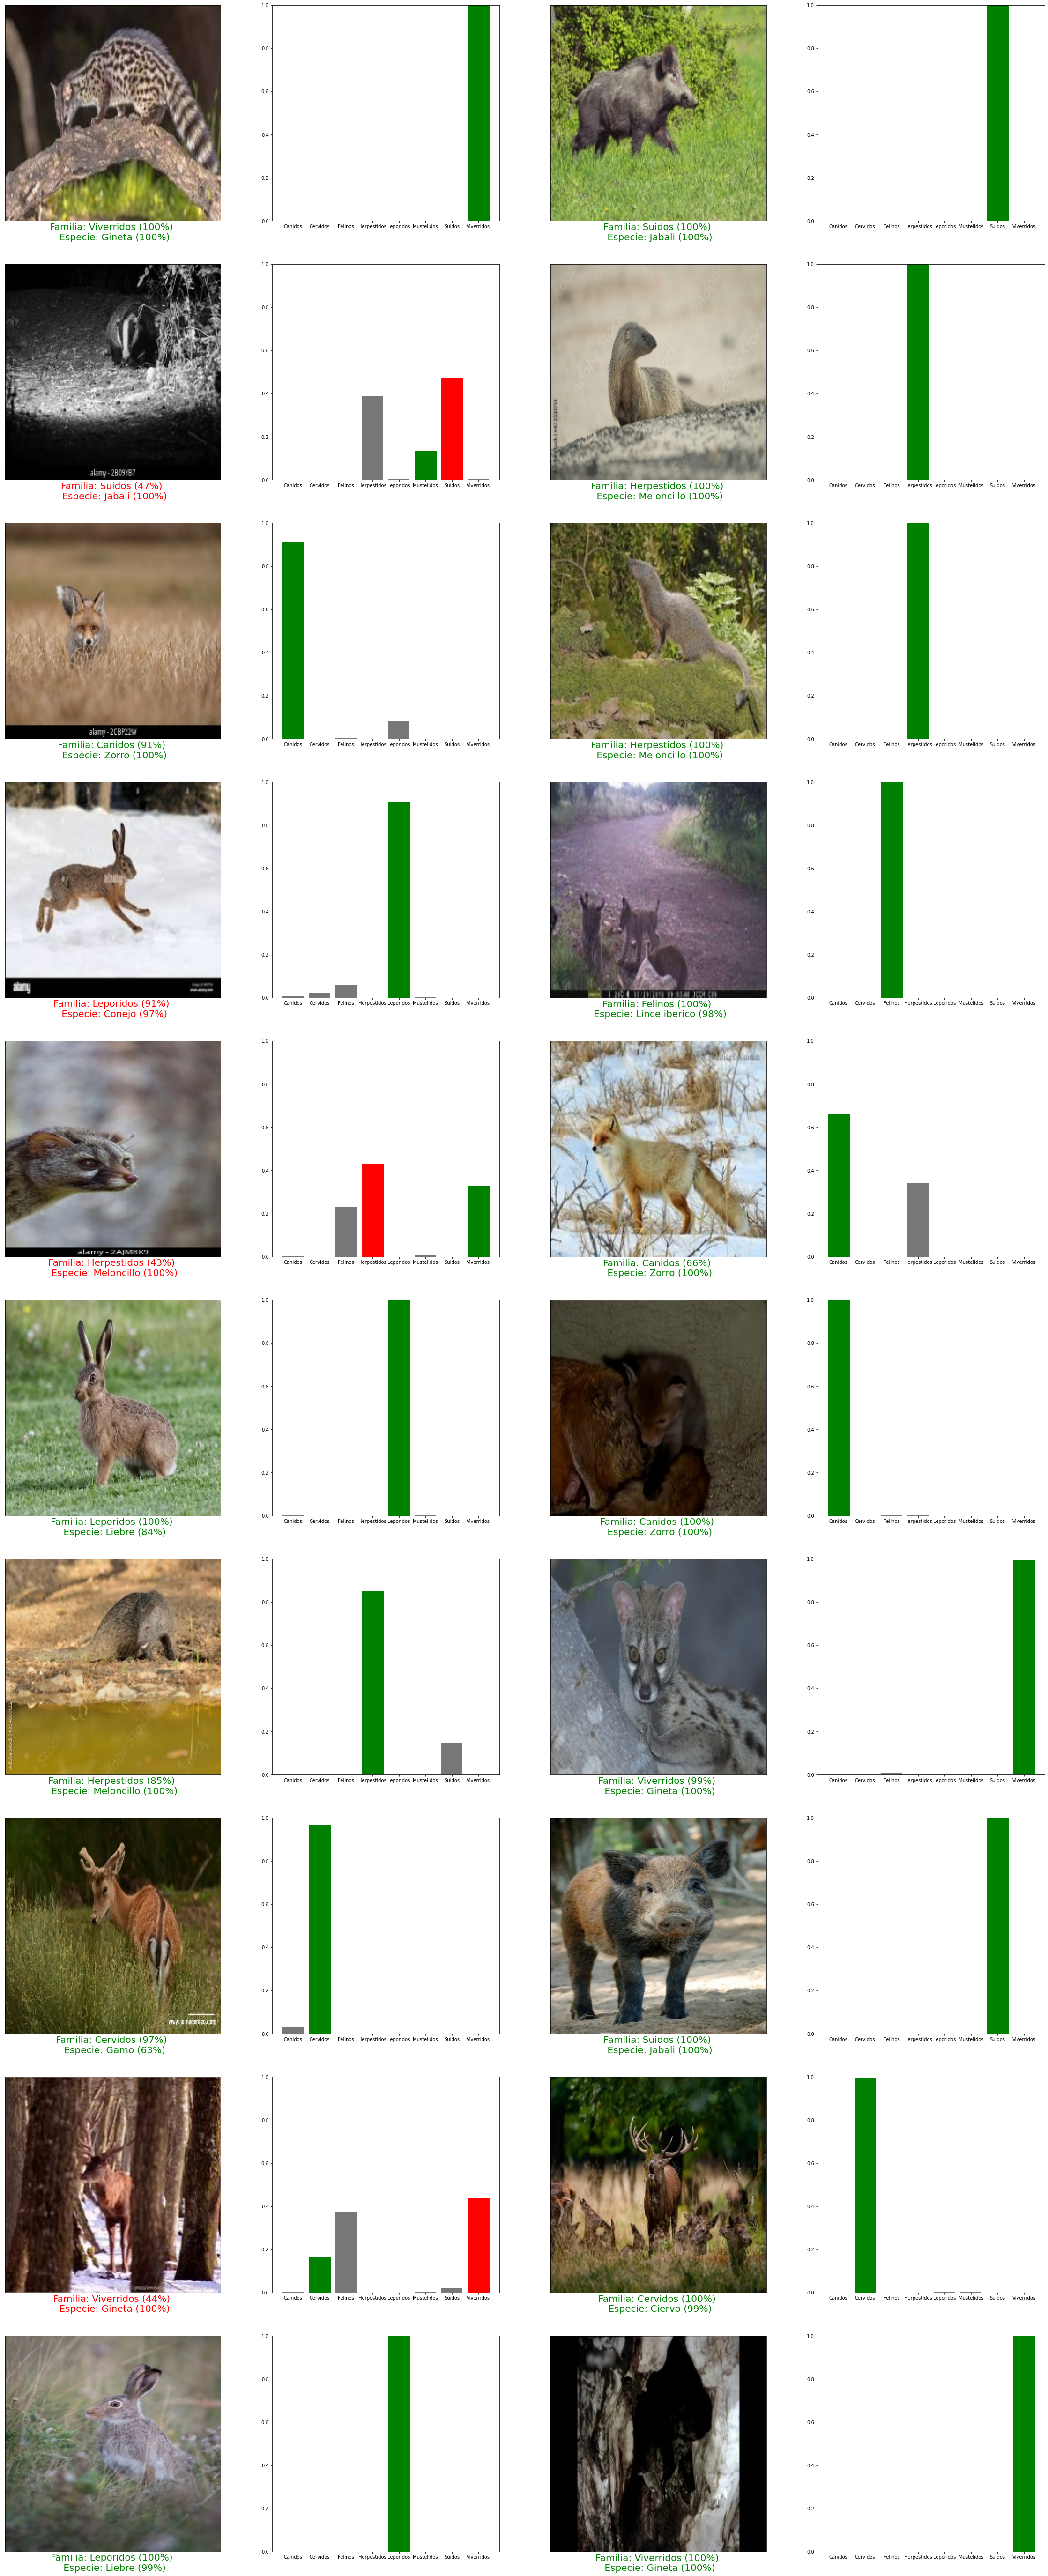

In [10]:
filas = 10
columnas = 2
num_imagenes = filas*columnas
images_show = images
random.shuffle(images_show)
plt.figure(figsize=(20*columnas, 10*filas))

for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(images_show[i])
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(images_show[i].categorie_predict_probability, images_show[i].categorie)

In [18]:
aciertos = 0
fallos = 0
for _img in images:
  if _img.subcategorie == _img.subcategorie_predict:
    aciertos += 1
  else:
    fallos +=1

total = len(images)
print (f'En la red Mobilenet V3 el número de aciertos es del {round(aciertos/total*100,2)}% y el número de fallos es del {round(fallos/total*100,2)}%')

En la red Mobilenet V3 el número de aciertos es del 89.64% y el número de fallos es del 10.36%


## Matrices de confusión
Esta herramienta permita visualizar los resultados de aciertos y fallos en una tabla. Los aciertos se dan cuando el True label coincide con el predicted label, es decir, los resultados serán mejores cuando las mayor parte de las imágenes "entren" en la diagonal principal de la matriz.

En este caso se analizarán las familias, siendo 100 imágenes si es una familia con una sola especie y siendo 200 imágenes si es una familia con 2 especies.

Text(0, 0.5, 'Familias reales')

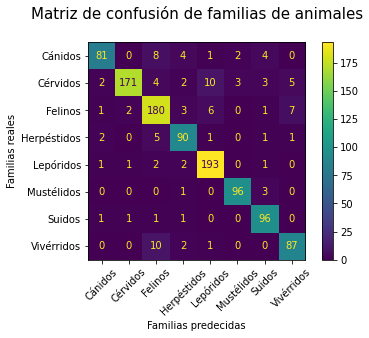

In [19]:
y_pred =[]
y_real =[]

for img in images:
  y_pred.append(img.categorie_predict)
  y_real.append(img.categorie)

target_names = ['Cánidos', 'Cérvidos', 'Felinos', 'Herpéstidos', 'Lepóridos', 'Mustélidos', 'Suidos', 'Vivérridos']
confusion_matrix = ConfusionMatrixDisplay.from_predictions(y_real, y_pred, display_labels=target_names, xticks_rotation=45)

plt.title('Matriz de confusión de familias de animales\n', fontsize=15)
plt.xlabel('Familias predecidas')
plt.ylabel('Familias reales')

En este caso se analizarán las especies de las familias con más de una especie, es decir, los cérvidos, los felinos y los lepóridos.

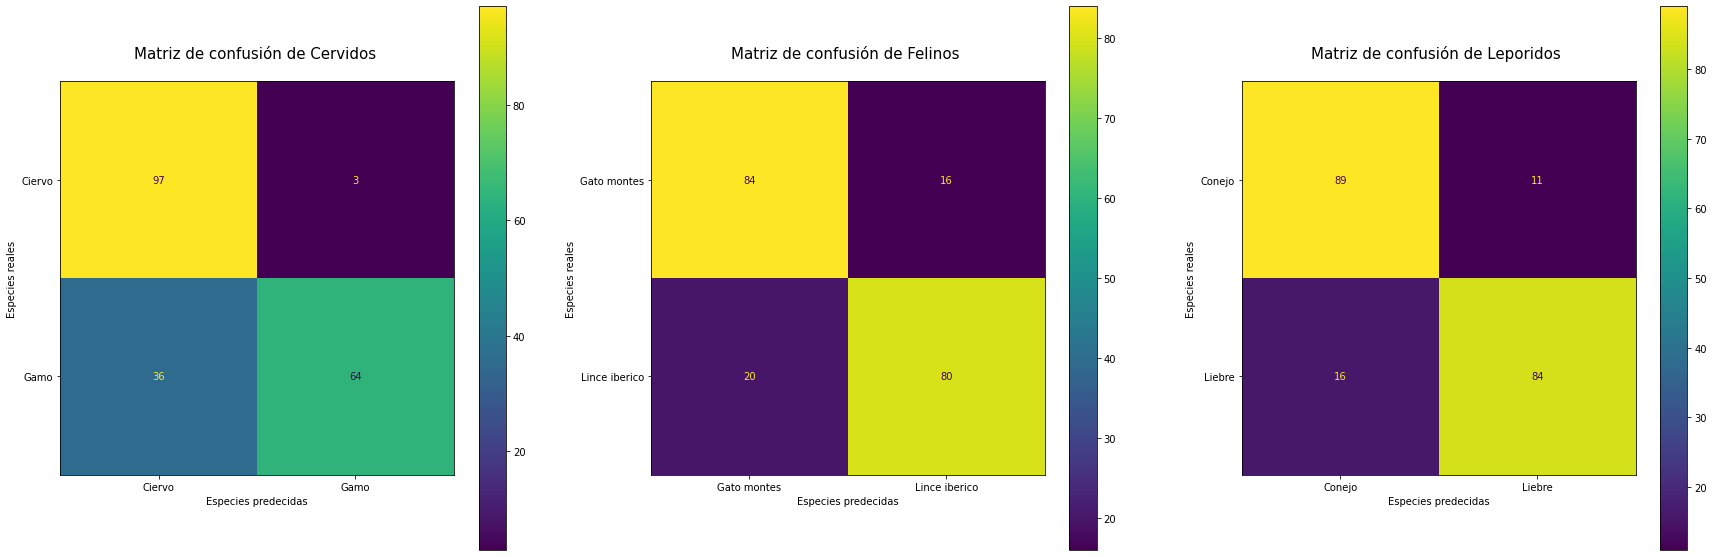

In [20]:
conf_arr = []

dict_etiquetas = {
    "Cervidos": {"etiquetas_reales":[], "etiquetas_predicciones":[], "etiquetas_reales_name":['Ciervo', 'Gamo']},
    "Felinos": {"etiquetas_reales":[], "etiquetas_predicciones":[], "etiquetas_reales_name":['Gato montes', 'Lince iberico']},
    "Leporidos": {"etiquetas_reales":[], "etiquetas_predicciones":[], "etiquetas_reales_name":['Conejo', 'Liebre']},
}

for img in images:
  if img.categorie_real_name in dict_modelos.keys():
    dict_etiquetas[img.categorie_real_name]["etiquetas_reales"].append(img.subcategorie)
    dict_etiquetas[img.categorie_real_name]["etiquetas_predicciones"].append(img.subcategorie_predict)

plt.figure(figsize=(30, 10))
for i, categorie in enumerate(dict_etiquetas.keys()):
  target_names_2 = dict_etiquetas[categorie]["etiquetas_reales_name"]
  conf_arr.append(ConfusionMatrixDisplay.from_predictions(dict_etiquetas[categorie]["etiquetas_reales"], dict_etiquetas[categorie]["etiquetas_predicciones"], display_labels=target_names_2, ax = plt.subplot(1, len(dict_etiquetas.keys()), i+1)))
  plt.title('Matriz de confusión de {} \n'.format(categorie), fontsize=15)
  plt.xlabel('Especies predecidas')
  plt.ylabel('Especies reales')


En este caso se puede observar que lo que más le cuesta identificar es a los gamos. Esto es debido a que en invierno pierden sus motas blancas tan características y puede llegar a ser complicado distinguirlos incluso entre los expertos. Aun así la cornamente presenta diferencias (en los gamos tienen forma de palas), pero las hembras de lejos es muy complicado distinguir unas de otras.